In [1]:
import numpy as np
import numpy.random as npr
from scipy.integrate import odeint
from scipy.special import digamma, polygamma

import matplotlib.pyplot as plt
import pandas as pd

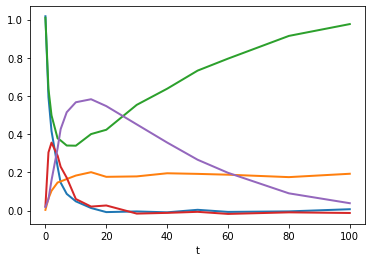

In [13]:
# Generate data 
def dstate_dt(state, t, *params):
    """
    Protein transduction model.
    """
    p1, p2, p3, p4, p5, p6 = params
    S = state[0]
    dS = state[1]
    R = state[2]
    Rs = state[3]
    Rpp = state[4]
    dstate = [-p1*S - p2*S*R + p3*R*S, 
              p1*S, 
              -p2*S*R + p3*Rs + p5*Rpp/(p6+Rpp),
             p2*S*R - p3*Rs - p4*Rs,
             p4*Rs - p5*Rpp/(p6+Rpp)]
    return np.stack(dstate)

init_rng = npr.RandomState(0)

t = [0., 1., 2., 4., 5., 7., 10., 15., 20., 30., 40., 50., 60., 80., 100.]
true_params = (0.07, 0.6, 0.05, 0.3, 0.017, 0.3)
init_state = [1.0, 0.0, 1.0, 0.0, 0.0]
sigma = 0.01

ode_solution = odeint(dstate_dt, np.array(init_state), np.array(t), args=true_params, rtol=1e-6, atol=1e-5, mxstep=1000)
yobs = ode_solution + sigma * init_rng.normal(size=(len(t),len(init_state)))

plt.plot(t, yobs, lw=2)
plt.xlabel('t')
plt.show()

In [138]:
shp = 1.
rt = 2.
dim = 6
mu_phi = (digamma(shp)-np.log(rt))*np.ones(dim)
Sigma_phi = polygamma(1, shp) * np.eye(dim)

# Setup sigma points
alpha = 1e-2
kappa = 0.
beta = 2.
lbda = (dim+kappa)*alpha**2-dim
Sigma_sqrt = np.sqrt((dim+lbda)*polygamma(1,shp))* np.eye(dim)
sigma_points = []
weights_m = []
weights_c = []
sigma_points.append(mu_phi)
weights_m.append(lbda/(dim+lbda))
weights_c.append(lbda/(dim+lbda)+1.-alpha**2+beta)

for i in range(dim):
    weights_m.append(0.5/(dim+lbda))
    weights_m.append(0.5/(dim+lbda))
    weights_c.append(0.5/(dim+lbda))
    weights_c.append(0.5/(dim+lbda))
    sigma_points.append(mu_phi+Sigma_sqrt[i])
    sigma_points.append(mu_phi-Sigma_sqrt[i])
    
sigma_points = np.array(sigma_points)
weights_m = np.array(weights_m)
weights_c = np.array(weights_c)

print(np.average(sigma_points, axis=0, weights=weights_m))
print(mu_phi)

[-1.27036285 -1.27036285 -1.27036285 -1.27036285 -1.27036285 -1.27036285]
[-1.27036285 -1.27036285 -1.27036285 -1.27036285 -1.27036285 -1.27036285]


In [139]:
# initial state
state_init = np.array([1.0, 0., 1.0, 0., 0.])
# measurement times
t = np.array([0., 1., 2., 4., 5., 7., 10., 15., 20., 30., 40., 50., 60., 80., 100])
# nl sigma ponts
nl_sigma_points = np.array([odeint(dstate_dt, state_init, t, args=tuple([np.exp(sigma_points[i,j]) for j in range(6)]), rtol=1e-6, atol=1e-5, mxstep=1000) 
                             for i in range(2*dim+1)])

$$
\begin{align}
\phi &= \log \theta \\
\mu_\phi &= \mathbb{E}[\phi] = \mathbb{E}[\log \theta] = \psi(\alpha)-\log \beta \\
\Sigma_{\phi\phi} &= \textrm{var}(\phi) I = \psi^{(1)}(\alpha) I
\end{align}
$$

In [140]:
# compute mu_y
mu_y = np.average(nl_sigma_points[:,1:], axis=0, weights=weights_m)
demeaned_y = (nl_sigma_points[:,1:]-mu_y).reshape((2*dim+1,(len(t)-1)*len(state_init)))
outer_demeaned = np.array([np.outer(demeaned_y[i],demeaned_y[i]) for i in range(2*dim+1)])
Sigma_yy = (sigma**2) * np.eye((len(t)-1)*len(state_init)) + np.average(outer_demeaned, axis=0, weights=weights_c)
demeaned_phi = (sigma_points-mu_phi)
outer_demeaned_phiy = np.array([np.outer(demeaned_phi[i],demeaned_y[i]) for i in range(2*dim+1)])
Sigma_phiy = np.average(outer_demeaned_phiy, axis=0, weights=weights_c)

In [141]:
mu_y = mu_y.reshape((len(t)-1)*len(state_init))
yobs_rs = yobs[1:].reshape((len(t)-1)*len(state_init))

S = np.linalg.inv(Sigma_yy)
H = Sigma_phiy
mu_post = mu_phi + np.dot(H,np.linalg.solve(Sigma_yy,yobs_rs-mu_y))
print(np.exp(mu_post))


[1.60847705e-01 2.86092147e-01 7.24232359e-02 3.50497508e-02
 2.88423573e-01 4.63321887e+03]


In [51]:
np.cov((weights_c*demeaned.T).T,demeaned).shape

(26, 26)

In [53]:
np.outer((weights_c*demeaned.T).T,demeaned).shape

(975, 975)

In [108]:
sigma_points

(13, 6)